In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import pickle
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as offline


from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans, DBSCAN
from nltk.util import ngrams
from nltk.text import TextCollection
from sklearn.decomposition import NMF
from gensim import corpora, models, similarities, matutils
from collections import Counter
from sklearn.manifold import TSNE

offline.init_notebook_mode()

In [2]:
data = pd.read_csv('profiles.csv')
X = data[['essay' + str(i) for i in range(10)]]
X = X.fillna('')
X = X.apply(lambda row: '\n'.join(row), axis=1).to_frame()
X = X[X[0].apply(lambda x: x.strip()) !='']
data = data.iloc[X.index]

In [3]:
def custom_tokenizer(text):
    text = strip_html_tags(text)
    
    remove_punct = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(remove_punct)
    
    remove_digits = str.maketrans('', '', string.digits)
    text = text.lower().translate(remove_digits)
    
    tokens = word_tokenize(text)
    
    stop_words = stopwords.words('english')
    tokens_stop = [y for y in tokens if y not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens_lemma = [lemmatizer.lemmatize(y) for y in tokens_stop]
    
    stemmer = SnowballStemmer('english')
    tokens_stem = [stemmer.stem(y) for y in tokens_lemma]
    
    custom_stop_words = ['like','love','good','thing','go','life',
                         'realli','also','think','one','want',
                        'probabl','im', 'would', 'dont', 'enjoy',
                         'lot', 'someth', 'favorit', 'make',
                         'even', 'usual', 'anything','could',
                        'know', 'get', 'anyth', 'sometim', 'come', 'actual', 'much',
                        'never', 'though', 'say', 'way', 'use', 'day', 'well',
                        'right', 'time', 'other', 'still', 'littl', 'need',
                        'bit', 'without', 'feel', 'find', 'got', 'seem']
    tokens_final = [y for y in tokens_stem if y not in custom_stop_words]
    
    return tokens_final

In [4]:
def print_topics(model, vectorizer, n_topics=10, top_n=10):
    for idx, topic in list(enumerate(model.components_))[:n_topics]:
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], '{:.4f}'.format(topic[i]))
                        for i,_ in sorted(enumerate(topic), key=lambda x: abs(x[1]))[-top_n:][::-1]])

In [8]:
data = data.reset_index(drop=True)

In [9]:
is_male = data.sex=='m'
print(data[is_male].shape)
print(data[~is_male].shape)

(34440, 31)
(23382, 31)


In [10]:
data[is_male]

age       body_type                 diet      drinks      drugs  \
0       22  a little extra    strictly anything    socially      never   
1       35         average         mostly other       often  sometimes   
2       38            thin             anything    socially        NaN   
3       23            thin           vegetarian    socially        NaN   
4       29        athletic                  NaN    socially      never   
5       29         average      mostly anything    socially        NaN   
9       37        athletic      mostly anything  not at all      never   
10      35         average      mostly anything    socially        NaN   
11      28         average      mostly anything    socially      never   
12      24             NaN                  NaN       often        NaN   
15      33             fit                  NaN    socially        NaN   
17      31         average    mostly vegetarian      rarely      never   
18      33        athletic      mostly anything    socially      never   
21      30             fit      mostly anything    socially      never   
22      30            thin       strictly vegan  not at all      never   
23      33            thin    strictly anything    socially  sometimes   
24      28             fit             anything      rarely      never   
25      22             fit      mostly anything    socially      never   
26      22         average             anything    socially      never   
27      30             fit                  NaN    socially        NaN   
28      32             fit                  NaN    socially  sometimes   
30      27        athletic             anything    socially      never   
33      27            thin    strictly anything    socially      never   
34      26        athletic                  NaN         NaN      never   
35      32        athletic      mostly anything    socially      never   
36      25             fit      mostly anything    socially        NaN   
38      35             fit                  NaN    socially        NaN   
39      30         average                  NaN       often      never   
40      35        athletic    strictly anything         NaN        NaN   
41      30         average    strictly anything       often  sometimes   
...    ...             ...                  ...         ...        ...   
57735   29             NaN                  NaN  not at all      never   
57737   31        athletic      mostly anything       often  sometimes   
57738   51         average      mostly anything      rarely      never   
57744   29         average      mostly anything    socially      never   
57746   32        athletic                  NaN    socially        NaN   
57750   33             fit             anything    socially      never   
57752   32             fit                  NaN    socially        NaN   
57753   19         average    mostly vegetarian      rarely      never   
57755   34         average                  NaN    socially      never   
57756   25         average                  NaN    socially      never   
57757   23         average             anything    socially      never   
57758   25        athletic      mostly anything    socially      never   
57769   30            thin      mostly anything    socially  sometimes   
57771   32         average      mostly anything    socially  sometimes   
57784   24          skinny             anything    socially  sometimes   
57787   23            thin      mostly anything    socially      never   
57792   28             NaN                  NaN    socially  sometimes   
57794   26             fit      mostly anything    socially      never   
57800   22      overweight    strictly anything    socially      never   
57805   29         average      mostly anything    socially      never   
57806   27         average  strictly vegetarian    socially  sometimes   
57807   24             fit  strictly vegetarian      rarely      never   
57808   21 

In [11]:
is_male.mean()

0.5956210438933278

## NMF

### tfidf

In [12]:
with open('matrix_tfidf.pkl', 'rb') as handle:
    X_tfidf = pickle.load(handle)
    
with open('tfidfvec.pkl', 'rb') as handle:
    tfidf = pickle.load(handle)

In [96]:
X_tfidf_male = X_tfidf[is_male.nonzero()[0]]
X_tfidf_female = X_tfidf[(~is_male).nonzero()[0]]

In [106]:
from collections import defaultdict

nmf_models = defaultdict(list)
nmf_mtxs = defaultdict(list)

In [107]:
for idx, mtx in enumerate([X_tfidf_male, X_tfidf_female]):
    for i in range(4, 11):
        nmf_tfidf = NMF(n_components=i, random_state=42)
        nmf_mtx = nmf_tfidf.fit_transform(mtx)
        nmf_models[idx].append(nmf_tfidf)
        nmf_mtxs[idx].append(nmf_mtx)
        print('\n' +'*'*50+'\n' + str(i) + ' Total Topics\n')
        print_topics(nmf_tfidf, tfidf, n_topics=i, top_n=10)


**************************************************
4 Total Topics

Topic 0:
[('peopl', '0.8486'), ('look', '0.6220'), ('someon', '0.5620'), ('person', '0.5255'), ('interest', '0.5004'), ('woman', '0.4808'), ('world', '0.4627'), ('take', '0.4361'), ('relationship', '0.4231'), ('see', '0.4161')]
Topic 1:
[('friend', '1.0732'), ('work', '0.8141'), ('new', '0.7700'), ('famili', '0.6886'), ('fun', '0.5800'), ('food', '0.5492'), ('travel', '0.4896'), ('movi', '0.4882'), ('sport', '0.4841'), ('tri', '0.4833')]
Topic 2:
[('music', '0.8288'), ('game', '0.6765'), ('movi', '0.6344'), ('book', '0.5744'), ('show', '0.5403'), ('food', '0.4813'), ('play', '0.4473'), ('rock', '0.3981'), ('read', '0.3860'), ('tv', '0.3632')]
Topic 3:
[('http', '0.9836'), ('com', '0.9354'), ('www', '0.9164'), ('http www', '0.9046'), ('youtub com', '0.8244'), ('www youtub', '0.8177'), ('youtub', '0.8076'), ('com watch', '0.7934'), ('watch v', '0.7824'), ('v', '0.6486')]

*************************************************

[('na', '1.3548'), ('wan', '1.2106'), ('wan na', '1.2099'), ('lol', '0.8145'), ('u', '0.6448'), ('n', '0.2999'), ('ask', '0.2821'), ('gon na', '0.2809'), ('gon', '0.2808'), ('u wan', '0.2333')]
Topic 7:
[('new', '1.7880'), ('meet', '1.1509'), ('peopl', '1.1103'), ('meet new', '0.8621'), ('new peopl', '0.8216'), ('tri', '0.6408'), ('tri new', '0.5054'), ('look', '0.3609'), ('new friend', '0.3496'), ('fun', '0.3342')]
Topic 8:
[('san', '0.9745'), ('year', '0.9059'), ('francisco', '0.8878'), ('san francisco', '0.8868'), ('work', '0.8715'), ('move', '0.7316'), ('citi', '0.6634'), ('bay', '0.6633'), ('live', '0.6260'), ('area', '0.6010')]

**************************************************
10 Total Topics

Topic 0:
[('peopl', '0.8868'), ('read', '0.7276'), ('pretti', '0.5564'), ('tri', '0.5471'), ('stuff', '0.4855'), ('mean', '0.4395'), ('write', '0.4381'), ('profil', '0.4366'), ('work', '0.4145'), ('question', '0.4142')]
Topic 1:
[('friend', '1.2547'), ('famili', '0.9628'), ('work', '0.811

[('friend', '1.2943'), ('famili', '1.1352'), ('famili friend', '0.7390'), ('laugh', '0.6363'), ('smile', '0.6171'), ('friend famili', '0.4863'), ('fun', '0.4631'), ('work', '0.3868'), ('someon', '0.3848'), ('great', '0.3351')]
Topic 2:
[('natur', '0.4176'), ('relationship', '0.4034'), ('art', '0.4009'), ('connect', '0.3782'), ('creativ', '0.3755'), ('open', '0.3641'), ('share', '0.3627'), ('world', '0.3569'), ('passion', '0.3465'), ('live', '0.3329')]
Topic 3:
[('peopl', '0.7418'), ('look', '0.4074'), ('messag', '0.3514'), ('take', '0.3353'), ('person', '0.3290'), ('mean', '0.3235'), ('pretti', '0.3152'), ('work', '0.3088'), ('date', '0.2994'), ('girl', '0.2989')]
Topic 4:
[('movi', '1.0927'), ('book', '0.8754'), ('food', '0.7850'), ('music', '0.7620'), ('watch', '0.6916'), ('read', '0.6205'), ('show', '0.5334'), ('game', '0.4799'), ('tv', '0.4560'), ('school', '0.4051')]
Topic 5:
[('new', '1.9775'), ('tri', '0.9202'), ('tri new', '0.8549'), ('meet', '0.8461'), ('peopl', '0.8380'), ('m

defaultdict(list,
            {0: [NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
                n_components=4, random_state=42, shuffle=False, solver='cd', tol=0.0001,
                verbose=0),
              NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
                n_components=5, random_state=42, shuffle=False, solver='cd', tol=0.0001,
                verbose=0),
              NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
                n_components=6, random_state=42, shuffle=False, solver='cd', tol=0.0001,
                verbose=0),
              NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
                n_components=7, random_state=42, shuffle=False, solver='cd', tol=0.0001,
                verbose=0),
              NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
                n_components=8, random_state=42, shuffle

In [201]:
# with open('nmf_model_tfidf.pkl', 'wb') as f:
#     pickle.dump(nmf_tfidf, f, protocol=pickle.HIGHEST_PROTOCOL)
# with open('nmf_mtx_tfidf.pkl', 'wb') as f:
#     pickle.dump(X_tfidf, f, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
# with open('nmf_models.pkl', 'wb') as f:
#     pickle.dump(nmf_models, f, protocol=pickle.HIGHEST_PROTOCOL)
# with open('nmf_mtxs.pkl', 'wb') as f:
#     pickle.dump(nmf_mtxs, f, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
nmf_models

[NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
   n_components=4, random_state=42, shuffle=False, solver='cd', tol=0.0001,
   verbose=0),
 NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
   n_components=5, random_state=42, shuffle=False, solver='cd', tol=0.0001,
   verbose=0),
 NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
   n_components=6, random_state=42, shuffle=False, solver='cd', tol=0.0001,
   verbose=0),
 NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
   n_components=7, random_state=42, shuffle=False, solver='cd', tol=0.0001,
   verbose=0),
 NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
   n_components=8, random_state=42, shuffle=False, solver='cd', tol=0.0001,
   verbose=0),
 NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
   n_components=9, random_state=42, shuffle=False, solver='cd', tol=0.0001,
 

In [237]:
# with open('nmf_model_tfidf.pkl', 'rb') as f:
#     nmf_tfidf = pickle.load(f)
# with open('nmf_mtx_tfidf.pkl', 'rb') as f:
#     X_tfidf = pickle.load(f)

In [8]:
# with open('nmf_models.pkl', 'rb') as f:
#     nmf_models = pickle.load(f)
# with open('nmf_mtxs.pkl', 'rb') as f:
#     nmf_mtxs = pickle.load(f)

### use 17 topics for NMF

In [48]:
# min_ratio = 1
# best_i = np.inf
# for i in np.linspace(.1,.2, 10):
#     clustering = DBSCAN(eps=i, metric='cosine', n_jobs=-1).fit(nmf_mtxs[13][:10000])
#     ratio = (clustering.labels_==-1).sum()/len(clustering.labels_)
#     print(i, ratio, len(np.unique(clustering.labels_)))
#     if ratio < min_ratio:
#         min_ratio = ratio
#         best_i = i
        
# print(min_ratio, best_i)

0.1 0.1065 9
0.11111111111111112 0.0459 3
0.12222222222222223 0.0199 2
0.13333333333333333 0.0097 2
0.14444444444444446 0.0053 2
0.15555555555555556 0.0027 2
0.16666666666666669 0.0019 2
0.17777777777777778 0.0014 2
0.18888888888888888 0.0009 2
0.2 0.0009 2
0.0009 0.18888888888888888


In [50]:
# clustering = DBSCAN(eps=.1111, metric='cosine', n_jobs=-1).fit(nmf_mtxs[13][:10000])
# clustering.labels_

# Counter(clustering.labels_)

Counter({0: 9537, -1: 459, 1: 4})

### try just grouping by topics

In [83]:
nmf_mtx = nmf_mtxs[13]
nmf_mtx[]

array([0.01760794, 0.        , 0.00129742, 0.01103027, 0.        ,
       0.        , 0.00462217, 0.00231842, 0.        , 0.00880287,
       0.03220564, 0.        , 0.00263868, 0.01141078, 0.00132018,
       0.01600371, 0.        ])

In [14]:
# nmf_tfidf = NMF(n_components=17, random_state=42)
# nmf_mtx = nmf_tfidf.fit_transform(X_tfidf)

In [15]:
# with open('nmf_tfidf.pkl', 'wb') as f:
#     pickle.dump(nmf_tfidf, f, protocol=pickle.HIGHEST_PROTOCOL)
# with open('nmf_mtx.pkl', 'wb') as f:
#     pickle.dump(nmf_mtx, f, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open('nmf_tfidf.pkl', 'rb') as f:
    nmf_tfidf = pickle.load(f)
with open('nmf_mtx.pkl', 'rb') as f:
    nmf_mtx = pickle.load(f)

In [16]:
print_topics(nmf_tfidf, tfidf, n_topics=17, top_n=20)

Topic 0:
[('peopl', '1.0900'), ('read', '0.7179'), ('pretti', '0.5791'), ('write', '0.5510'), ('mean', '0.5506'), ('tri', '0.5271'), ('stuff', '0.5095'), ('profil', '0.5030'), ('talk', '0.4933'), ('question', '0.4853'), ('tell', '0.4835'), ('ask', '0.4715'), ('see', '0.4663'), ('first', '0.4654'), ('take', '0.4648'), ('ever', '0.4299'), ('messag', '0.4221'), ('oh', '0.4066'), ('might', '0.4013'), ('alway', '0.4002')]
Topic 1:
[('travel', '0.9967'), ('bike', '0.8429'), ('wine', '0.6955'), ('hike', '0.6310'), ('cook', '0.6082'), ('adventur', '0.5892'), ('run', '0.5439'), ('trip', '0.5362'), ('next', '0.5269'), ('outdoor', '0.4966'), ('ride', '0.4579'), ('activ', '0.4320'), ('dinner', '0.4217'), ('live', '0.4178'), ('citi', '0.4165'), ('weekend', '0.4073'), ('ski', '0.3834'), ('great', '0.3804'), ('place', '0.3718'), ('drink', '0.3693')]
Topic 2:
[('world', '0.5125'), ('open', '0.5077'), ('connect', '0.4714'), ('natur', '0.4706'), ('relationship', '0.4622'), ('learn', '0.4291'), ('passion

### Key for topics

|Number | Topic|
|-------|---|
|0 | catchall|
|1 | adventurous|
|2 | spiritual, openness|
|3 | work |
|4 | art, creative|
|5 | web links|
|6 | movies/books/music (essay question)|
|7 | meet ppl / try new things|
|8 | san francisco|
|9 | movies/books/music|
|10| gaming nerds|
|11| school in bay area|
|12| friends, family|
|13| sense of humor|
|14| dance, sing, party|
|15| what they're looking for|
|16| bad grammar/spelling|

In [91]:
for i in range(10):

[0.01760794 0.         0.00129742 0.01103027 0.         0.
 0.00462217 0.00231842 0.         0.00880287 0.03220564 0.
 0.00263868 0.01141078 0.00132018 0.01600371 0.        ]
[0.00937561 0.01234407 0.00445036 0.00885001 0.00118412 0.00043577
 0.01231488 0.00890203 0.         0.00047082 0.00319656 0.
 0.         0.00929889 0.00164827 0.01268325 0.00103613]
[0.0214323  0.         0.02323191 0.         0.02600161 0.
 0.0039572  0.01211314 0.01172833 0.01005067 0.         0.
 0.00262962 0.0062364  0.01974262 0.         0.        ]
[0.00426214 0.         0.0053079  0.00859214 0.00425537 0.00031982
 0.00144916 0.00037904 0.         0.01352892 0.00123118 0.0002163
 0.         0.         0.         0.         0.        ]
[0.00020046 0.         0.         0.03106016 0.00800064 0.03509975
 0.00642359 0.01092639 0.         0.00527316 0.         0.
 0.00428703 0.         0.         0.00747661 0.        ]
[0.02410841 0.         0.00141526 0.         0.0037341  0.
 0.00149287 0.00741785 0.01529053 0

In [111]:
classified = np.argmax(nmf_mtx, axis=1)

In [112]:
Counter(classified)

Counter({10: 2146,
         15: 2385,
         4: 2505,
         9: 4529,
         5: 1230,
         0: 6238,
         2: 7180,
         1: 6349,
         6: 3685,
         3: 2744,
         11: 4417,
         14: 2315,
         16: 2172,
         7: 1781,
         8: 2904,
         13: 2627,
         12: 2615})

In [113]:
classified

array([10, 15,  4, ..., 11, 16,  0])

Group similar topics together:
9->6
11->8

In [114]:
nmf_mtx[:, 6] += nmf_mtx[:, 9]
nmf_mtx[:, 8] += nmf_mtx[:, 11]

In [115]:
nmf_mtx_trimmed = np.delete(nmf_mtx, [9,11], axis=1)

|Number | Topic|
|-------|---|
|0 | catchall|
|1 | adventurous|
|2 | spiritual, openness|
|3 | work |
|4 | art, creative|
|5 | web links|
|6 | movies/books/music (essay question)|
|7 | meet ppl / try new things|
|8 | san francisco, bay area|
|9| gaming nerds|
|10| friends, family|
|11| sense of humor|
|12| dance, sing, party|
|13| what they're looking for|
|14| bad grammar/spelling|

In [116]:
classified = np.argmax(nmf_mtx_trimmed, axis=1)
Counter(classified)

Counter({9: 1830,
         6: 12692,
         4: 2120,
         5: 1156,
         0: 5142,
         2: 6545,
         1: 5244,
         3: 2352,
         8: 8560,
         14: 1975,
         7: 1508,
         12: 2024,
         11: 2286,
         10: 2200,
         13: 2188})

In [218]:
topic_dict = {0: 'Misc', 1: 'Adventurous', 2: 'Spiritual, Openness', 3: 'Work',
             4: 'Art, Creative', 5: 'Contains Web Links', 6: 'Movies/Books/Music',
             7: 'New People/Things', 8: 'SF / Bay Area', 9: 'Gaming Nerds',
             10: 'Friends, Family', 11: 'Sense of Humor', 12: 'Dance, Sing, Party',
             13: 'Looking for ...', 14: 'Bad Grammar/Spelling'}

In [189]:
baseline_percent_diff = 100*(2*(data.sex =='m').mean()-1)
baseline_percent_diff

19.12420877866556

In [219]:
topics_mf_percents = []

for i in range(15):
    percent_male=100*(data[classified==i].sex=='m').mean()
    percent_female = 100-percent_male
    print('topic {} has {:.4f} percent males, {:.4f} percent females'.format(topic_dict[i], percent_male, 100-percent_male))
    print('percent diff male minus female (baseline-adjusted): {}'.format(percent_male - percent_female - baseline_percent_diff))
    print(50*'*')
    topics_mf_percents.append((topic_dict[i], percent_male-percent_female-baseline_percent_diff))


topic Misc has 65.2275 percent males, 34.7725 percent females
percent diff male minus female (baseline-adjusted): 11.330867067308773
**************************************************
topic Adventurous has 53.7567 percent males, 46.2433 percent females
percent diff male minus female (baseline-adjusted): -11.61086018980211
**************************************************
topic Spiritual, Openness has 51.1383 percent males, 48.8617 percent females
percent diff male minus female (baseline-adjusted): -16.847661796236224
**************************************************
topic Work has 69.8980 percent males, 30.1020 percent females
percent diff male minus female (baseline-adjusted): 20.671709588681395
**************************************************
topic Art, Creative has 62.0283 percent males, 37.9717 percent females
percent diff male minus female (baseline-adjusted): 4.932394994919335
**************************************************
topic Contains Web Links has 74.3080 percent male

In [220]:
topics_mf_percents = sorted(topics_mf_percents, key=lambda x: x[1])
topics_mf_percents

[('Dance, Sing, Party', -36.12025620949561),
 ('Friends, Family', -25.578754233211015),
 ('Spiritual, Openness', -16.847661796236224),
 ('Adventurous', -11.61086018980211),
 ('Sense of Humor', -10.025346136495841),
 ('Movies/Books/Music', 0.3526270234144988),
 ('Looking for ...', 3.6363031043326117),
 ('New People/Things', 4.350592282342404),
 ('Art, Creative', 4.932394994919335),
 ('SF / Bay Area', 5.455230473670895),
 ('Misc', 11.330867067308773),
 ('Bad Grammar/Spelling', 18.799841854245827),
 ('Work', 20.671709588681395),
 ('Contains Web Links', 29.491708176351736),
 ('Gaming Nerds', 37.81568193171695)]

In [221]:
topics, topic_percents = list(zip(*topics_mf_percents))
topics

('Dance, Sing, Party',
 'Friends, Family',
 'Spiritual, Openness',
 'Adventurous',
 'Sense of Humor',
 'Movies/Books/Music',
 'Looking for ...',
 'New People/Things',
 'Art, Creative',
 'SF / Bay Area',
 'Misc',
 'Bad Grammar/Spelling',
 'Work',
 'Contains Web Links',
 'Gaming Nerds')

In [223]:
traceBar = go.Bar(y=topics, x=topic_percents, orientation='h')
layout = dict(margin=dict(
        l=200,
    ))
offline.iplot(go.Figure(data=[traceBar], layout=layout))

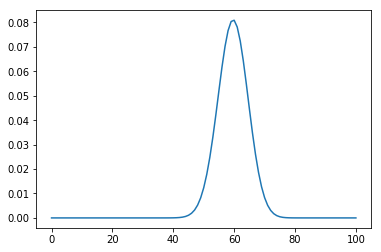

In [167]:
import matplotlib.pyplot as plt
import scipy, scipy.stats
x = scipy.linspace(0,100,101)
pmf = scipy.stats.binom.pmf(x, 100, is_male.mean())
plt.plot(x, pmf)

In [178]:
100*(data[classified==12].sex=='m').mean()

41.50197628458498

In [182]:
trace1 = go.Scatter(
    x = x,
    y = pmf,
    mode = 'lines',
    fill = 'tozeroy'
)
# male_12 = 100*(data[classified==12].sex=='m').mean()
# layout = {
#     'shapes': [
#         # Line Vertical
#         {
#             'type': 'line',
#             'x0': male_12,
#             'y0': 0,
#             'x1': male_12,
#             'y1': 2,
#             'line': {
#                 'color': 'rgb(55, 92, 20)',
#                 'width': 3,
#             }
#         }
#     ]
# }
# fig = {
#     'data': [trace1],
#     'layout': layout,
# }
offline.iplot([trace1])

In [35]:
topic_num = 14
for sample in X[0][classified==topic_num].sample(3):
    print(sample)
    print('\n'+'*'*50+'\n')

well,i just moved to the east bay from minnesota and ok here it
goes, a lil' something/something about me: smart, hilarious,
sarcastic, positive cynical, nerd, energetic, open minded, goofy
minded, a wordsmith, experimental, experienced
humorist,enthusiastic, outgoingly sociable, intelligent, awesomely
awesome, psychodelic, genuine, realistic, funniest dude you ever
met, focused (yet confused), daring, strong work ethic,
professional beertician, adventurer, traveler(amongst bars and
pubs), weird(in a good way), non-creepy(follow up to last comment),
conversationslist, lover, fighter, winner, loser(of being lame),
thinker, talkative, listenative, and more!!!**<br />
i'm looking for someone real that knows how to laugh at the
bullsh*tlife brings.
working in sonoma, digital label printing.
making people laugh, walking, being fly, breathing, meaningless and
meaningful conversation
my infinite charm
its always sunny in philadelphia, all zombie movies, the walking
dead, sushi, dubstep, bass,

In [117]:
X[0].shape

(57822,)

In [328]:
nmf_mtx_trimmed.shape

(57822, 15)

In [148]:
# tsne = TSNE(n_components=2, perplexity=30, n_iter=1200, metric='cosine', init='pca', random_state=42, verbose=1)
# trans_data = tsne.fit_transform(nmf_mtx_trimmed).T

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 57822 samples in 0.001s...
[t-SNE] Computed neighbors for 57822 samples in 80.941s...
[t-SNE] Computed conditional probabilities for sample 1000 / 57822
[t-SNE] Computed conditional probabilities for sample 2000 / 57822
[t-SNE] Computed conditional probabilities for sample 3000 / 57822
[t-SNE] Computed conditional probabilities for sample 4000 / 57822
[t-SNE] Computed conditional probabilities for sample 5000 / 57822
[t-SNE] Computed conditional probabilities for sample 6000 / 57822
[t-SNE] Computed conditional probabilities for sample 7000 / 57822
[t-SNE] Computed conditional probabilities for sample 8000 / 57822
[t-SNE] Computed conditional probabilities for sample 9000 / 57822
[t-SNE] Computed conditional probabilities for sample 10000 / 57822
[t-SNE] Computed conditional probabilities for sample 11000 / 57822
[t-SNE] Computed conditional probabilities for sample 12000 / 57822
[t-SNE] Computed conditional probabilities for sa

In [145]:
with open('tsne.pkl', 'wb') as f:
    pickle.dump(trans_data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [318]:
with open('tsne.pkl', 'rb') as f:
    trans_data = pickle.load(f)

In [319]:
trans_data

array([[  5.6121397,  -8.813191 , -32.212864 , ...,  47.83225  ,
        -23.985296 , -37.00264  ],
       [-52.43194  ,  38.931374 ,  16.106646 , ..., -30.714285 ,
        -44.763187 , -13.115915 ]], dtype=float32)

In [324]:
[topic_dict[i] for i in classified]

['Gaming Nerds',
 'Movies/Books/Music',
 'Art, Creative',
 'Movies/Books/Music',
 'Contains Web Links',
 'Misc',
 'Spiritual, Openness',
 'Adventurous',
 'Contains Web Links',
 'Movies/Books/Music',
 'Movies/Books/Music',
 'Misc',
 'Movies/Books/Music',
 'Movies/Books/Music',
 'Work',
 'SF / Bay Area',
 'Misc',
 'Adventurous',
 'SF / Bay Area',
 'Adventurous',
 'SF / Bay Area',
 'Adventurous',
 'Movies/Books/Music',
 'Movies/Books/Music',
 'Adventurous',
 'Work',
 'Gaming Nerds',
 'Adventurous',
 'Movies/Books/Music',
 'Bad Grammar/Spelling',
 'Movies/Books/Music',
 'Adventurous',
 'Bad Grammar/Spelling',
 'Movies/Books/Music',
 'New People/Things',
 'SF / Bay Area',
 'Dance, Sing, Party',
 'Spiritual, Openness',
 'Misc',
 'Misc',
 'Sense of Humor',
 'Movies/Books/Music',
 'Spiritual, Openness',
 'SF / Bay Area',
 'Dance, Sing, Party',
 'SF / Bay Area',
 'SF / Bay Area',
 'Misc',
 'Friends, Family',
 'Contains Web Links',
 'Adventurous',
 'New People/Things',
 'Spiritual, Openness',
 '

In [326]:
trace = go.Scattergl(x=trans_data[0], y=trans_data[1], 
                   hoverinfo='text',
                   text=[topic_dict[i] for i in classified],
                   mode='markers', 
                   marker=dict(color=classified, 
                               colorscale='Jet',
                               showscale=False
                               ))

In [329]:
py.iplot([trace])

In [227]:
data.isnull().sum()

age                0
body_type       5088
diet           23383
drinks          2723
drugs          13740
education       6082
essay0          3364
essay1          5448
essay2          7514
essay3          9352
essay4          8413
essay5          8726
essay6         11647
essay7         10327
essay8         17101
essay9         10479
ethnicity       5318
height             2
income             0
job             7622
last_online        0
location           0
offspring      34265
orientation        0
pets           18853
religion       19223
sex                0
sign           10402
smokes          5165
speaks            41
status             0
dtype: int64

In [229]:
data.age.value_counts()

26     3605
27     3538
28     3474
25     3433
29     3194
24     3130
30     3046
31     2647
23     2499
32     2493
33     2135
22     1876
34     1841
35     1695
36     1527
37     1385
38     1272
21     1229
39     1133
42     1029
40      989
41      931
20      920
43      812
44      670
45      619
19      588
46      549
47      514
48      461
49      440
50      420
51      333
52      328
18      295
56      260
55      255
54      251
57      244
53      242
59      207
58      193
60      193
61      169
62      161
63      133
64      106
66      102
65      101
67       66
68       58
69       30
109       1
Name: age, dtype: int64

Remove outlier age

In [262]:
data = data[data.age < 80]

### examine average age of topics

In [272]:
data.age.median()

30.0

In [273]:
topic_ages = []
for i in range(15):
    print(topic_dict[i], (data[classified==i].age).median())
    topic_ages.append((topic_dict[i], data[classified==i].age))

Misc 30.0
Adventurous 32.0
Spiritual, Openness 39.0
Work 29.0
Art, Creative 31.0
Contains Web Links 28.0
Movies/Books/Music 28.0
New People/Things 28.0
SF / Bay Area 29.0
Gaming Nerds 26.0
Friends, Family 30.0
Sense of Humor 33.0
Dance, Sing, Party 30.0
Looking for ... 33.0
Bad Grammar/Spelling 25.0


In [278]:
topic_ages = sorted(topic_ages, key=lambda x: x[1].median())

In [294]:
topic_ages = topic_ages[:3]+topic_ages[-4:]

In [295]:
topics, topic_age_series = list(zip(*topic_ages))

In [316]:
x_data = topics

y_data = topic_age_series

cmap = plt.get_cmap('Accent')
colors = [str('rgba{}'.format(cmap(i))) for i in np.linspace(0, 1, len(x_data))]
# colors = ['rgba({}, {}, {}, 0.5)'.format(np.random.rand(), np.random.rand(), np.random.rand()) for _ in range(len(x_data))]

# colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']

traces = []

for xd, yd, cls in zip(x_data, y_data, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

layout = go.Layout(
    title='Age Distribution by Topic',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False
)

fig = go.Figure(data=traces, layout=layout)
offline.iplot(fig)

In [299]:
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, len(x_data))]
colors

[(0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0),
 (0.9139561707035756, 0.36239907727797, 0.27935409457900806, 1.0),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587, 1.0),
 (0.998077662437524, 0.9992310649750096, 0.7460207612456747, 1.0),
 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569, 1.0),
 (0.3280276816608997, 0.6805074971164936, 0.6802768166089965, 1.0),
 (0.3686274509803922, 0.30980392156862746, 0.6352941176470588, 1.0)]

In [13]:
from wordcloud import WordCloud

In [27]:
nmf_tfidf.components_.shape

(17, 45269)

In [30]:
tfidf.get_feature_names()

['aa',
 'aaliyah',
 'aaron',
 'aaron sorkin',
 'aau',
 'ab',
 'abalon',
 'abandon',
 'abandon build',
 'abba',
 'abbey',
 'abbey music',
 'abbi',
 'abbrevi',
 'abc',
 'abe',
 'abhor',
 'abid',
 'abil',
 'abil communic',
 'abil count',
 'abil creat',
 'abil laugh',
 'abil learn',
 'abil listen',
 'abil peopl',
 'abil see',
 'abil travel',
 'abl',
 'abl communic',
 'abl express',
 'abl fun',
 'abl give',
 'abl handl',
 'abl help',
 'abl hold',
 'abl keep',
 'abl laugh',
 'abl live',
 'abl play',
 'abl put',
 'abl read',
 'abl see',
 'abl share',
 'abl spend',
 'abl take',
 'abl talk',
 'abl tell',
 'abl travel',
 'abl walk',
 'abl work',
 'abnorm',
 'aboard',
 'abomin',
 'abort',
 'abound',
 'abraham',
 'abraham lincoln',
 'abram',
 'abras',
 'abridg',
 'abroad',
 'abroad year',
 'abrupt',
 'absenc',
 'absent',
 'absent mind',
 'absinth',
 'absolut',
 'absolut ador',
 'absolut amaz',
 'absolut everyth',
 'absolut fabul',
 'absolut hate',
 'absolut job',
 'absolut live',
 'absolut movi',


In [41]:
top_words_per_topic_list = []

for idx, topic in enumerate(nmf_tfidf.components_):
    d = dict()
    for i, _ in sorted(enumerate(topic), key=lambda x: abs(x[1]))[-20:][::-1]:
        d[tfidf.get_feature_names()[i]] = topic[i]
#     tfidf.get_feature_names()[i]
#     print("Topic %d:" % (idx))
#     print([(vectorizer.get_feature_names()[i], '{:.4f}'.format(topic[i]))
#                     for i,_ in sorted(enumerate(topic), key=lambda x: abs(x[1]))[-20:][::-1]])
    top_words_per_topic_list.append(d)
top_words_per_topic_list

[{'peopl': 1.0899500773527317,
  'read': 0.7178688007396496,
  'pretti': 0.5791133422082774,
  'write': 0.5509516853935461,
  'mean': 0.5505613924760677,
  'tri': 0.5271122753268974,
  'stuff': 0.509481254814655,
  'profil': 0.5030407356664153,
  'talk': 0.4932706111954804,
  'question': 0.4852654798417172,
  'tell': 0.48347702356171285,
  'ask': 0.47154397087221067,
  'see': 0.46634506401831655,
  'first': 0.4653717930447826,
  'take': 0.4647756573498628,
  'ever': 0.42986205162465735,
  'messag': 0.42214682031409845,
  'oh': 0.4066499659315729,
  'might': 0.4013207324897276,
  'alway': 0.40018058779971055},
 {'travel': 0.9966866252571266,
  'bike': 0.8429343947983964,
  'wine': 0.6955118214940443,
  'hike': 0.630981498992658,
  'cook': 0.6081602408606713,
  'adventur': 0.5892416547919198,
  'run': 0.5439328880724393,
  'trip': 0.5361515864763872,
  'next': 0.5268805175396244,
  'outdoor': 0.4966497099166798,
  'ride': 0.45794045016478996,
  'activ': 0.4320188624846973,
  'dinner': 0.

17

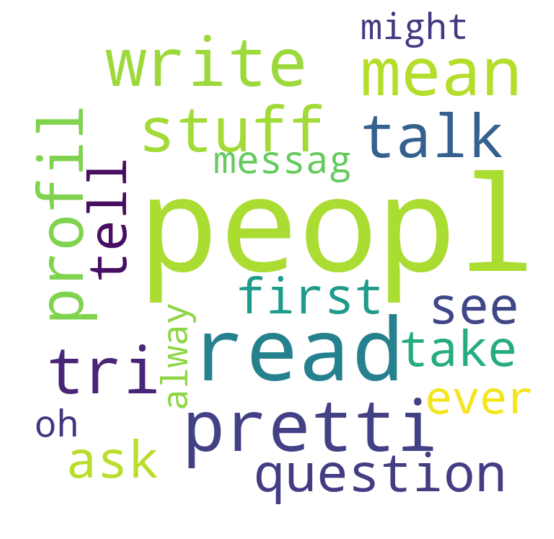

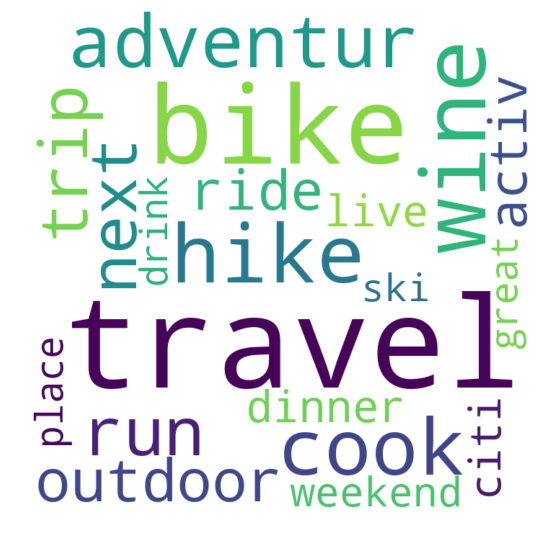

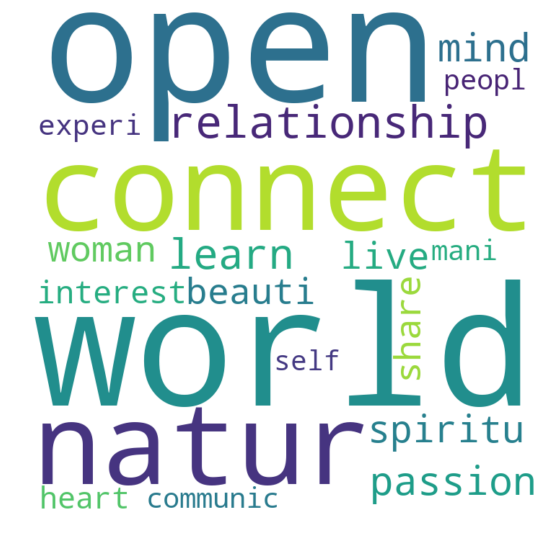

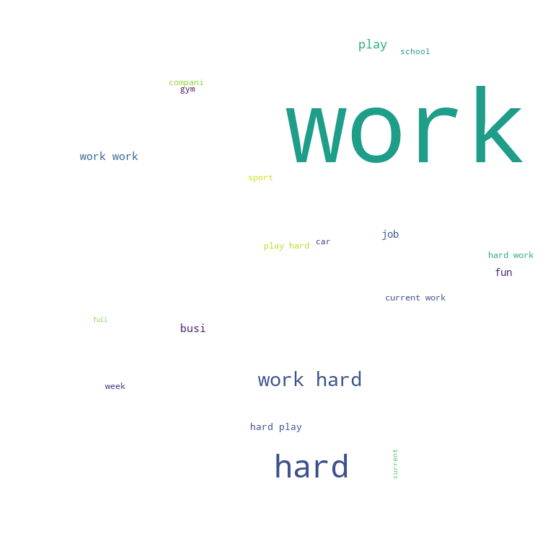

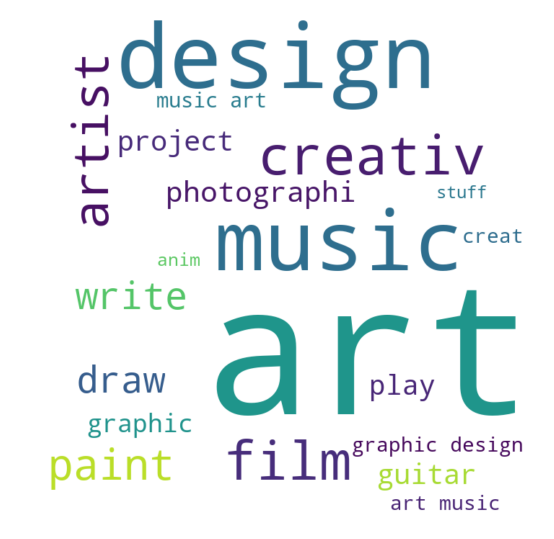

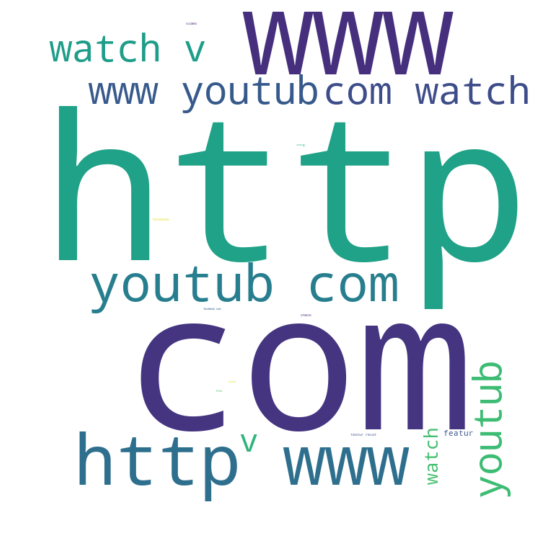

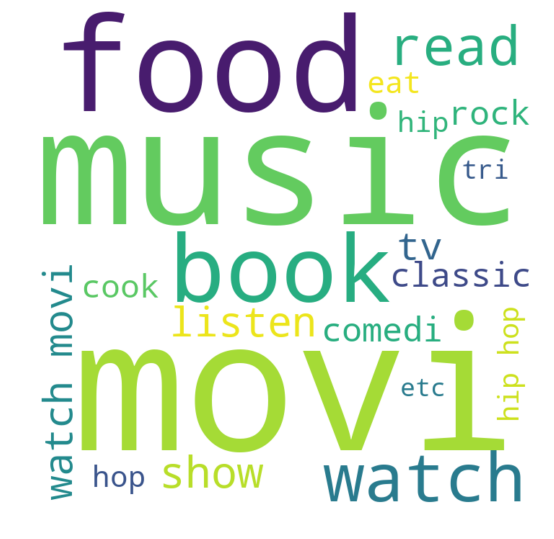

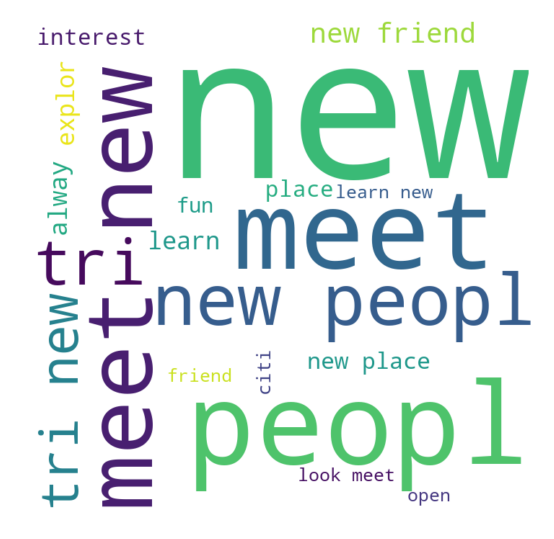

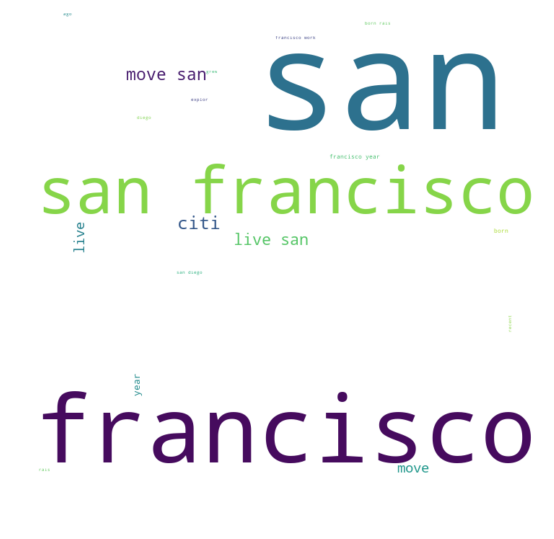

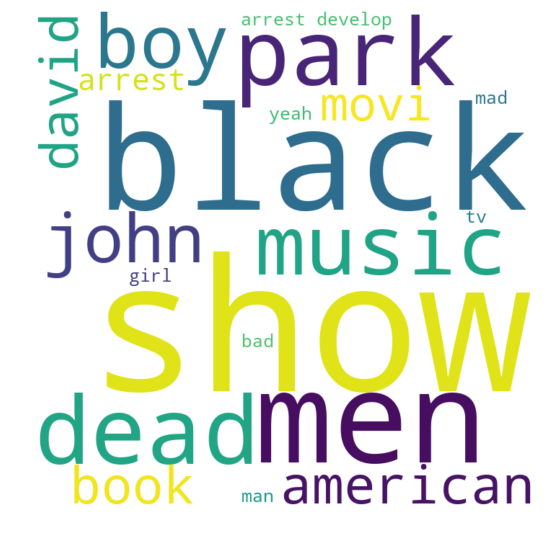

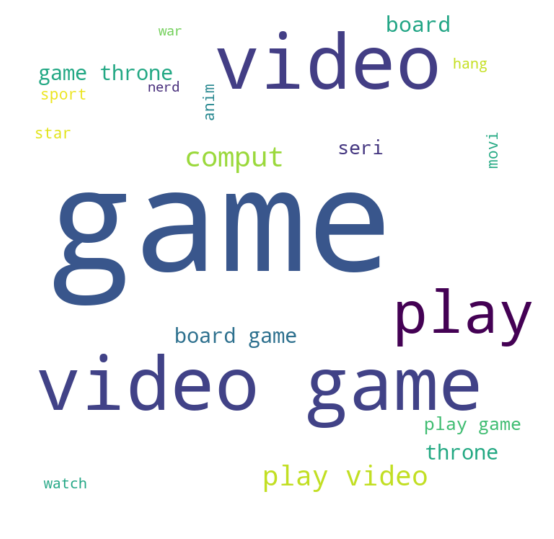

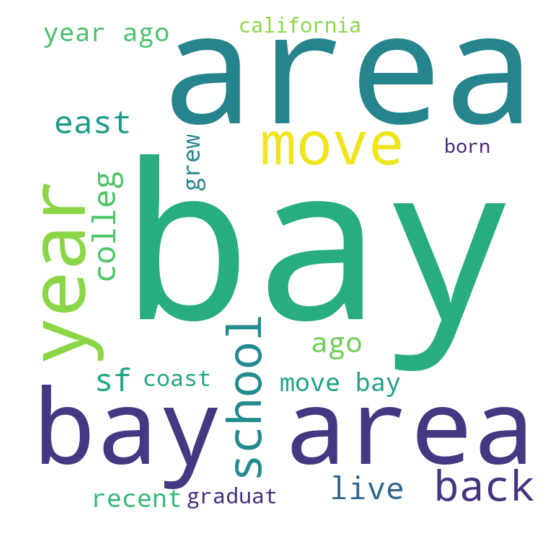

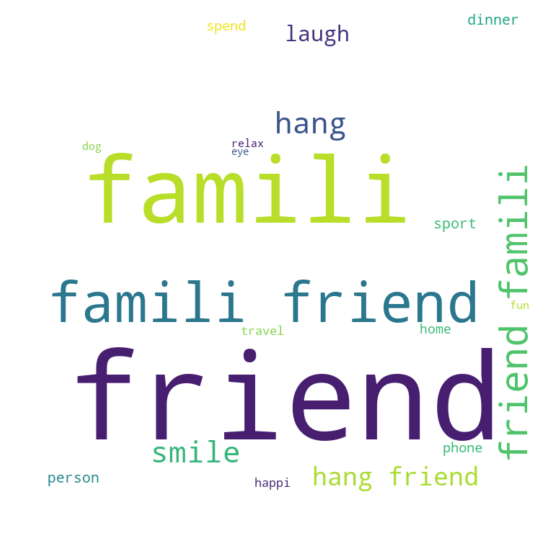

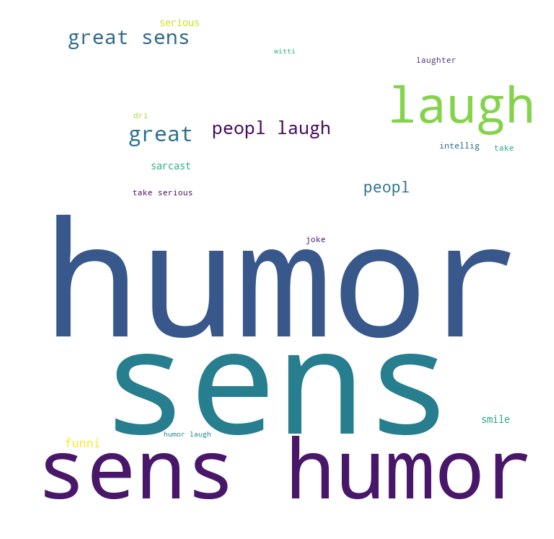

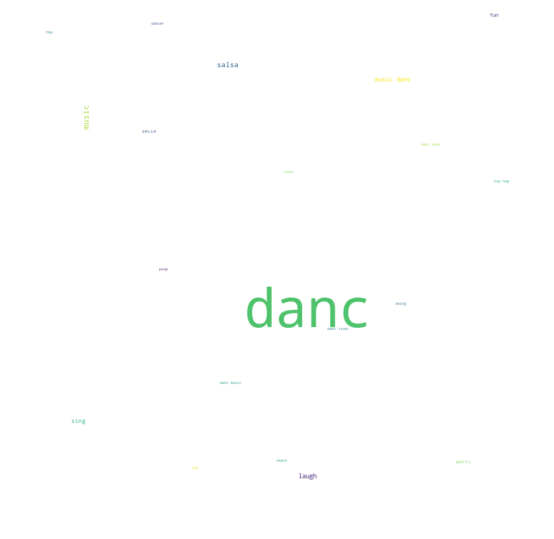

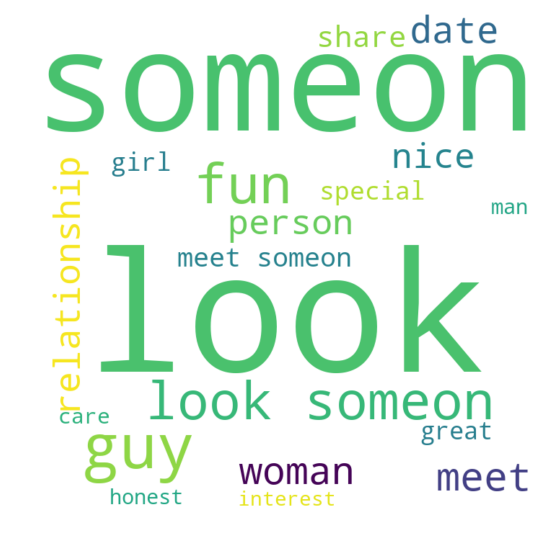

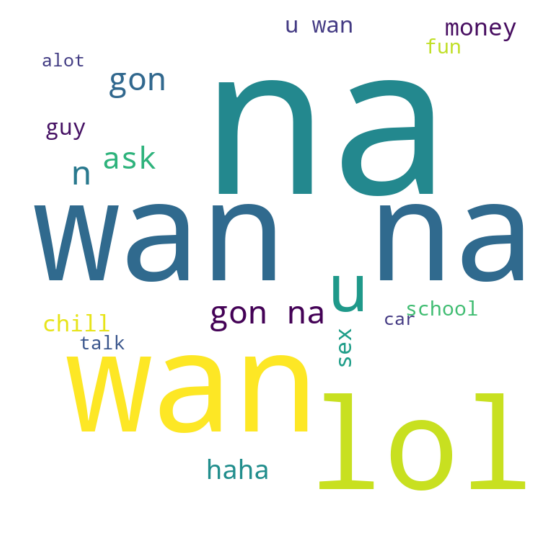

In [84]:
for i in range(17):
    wordcloud = WordCloud(relative_scaling=1, width=700, height=700, background_color='white').generate_from_frequencies(top_words_per_topic_list[i])
    plt.figure(figsize=(7,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.axis("off")
    plt.savefig('wordcloud{}.png'.format(i), bbox_inches='tight', pad_inches=0)
    plt.show()